# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

For Google Colab or Kaggle install crysx_nn

In [ ]:
! pip install --upgrade https://github.com/manassharma07/crysx_nn/tarball/main

## Import stuff

In [1]:
import numpy as np
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\network.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [6]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [10]:
nInputs = 2 # No. of features
nOutputs = 1
neurons_per_layer = [2000,2000,2000,1] # Hidden layers and output layer
activation_func_names = ['Sigmoid','Sigmoid','Sigmoid','Sigmoid',]
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4
batchSize = 4

#### Activation function dictionary for all the frameworks

In [11]:


act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}



## Visualize 

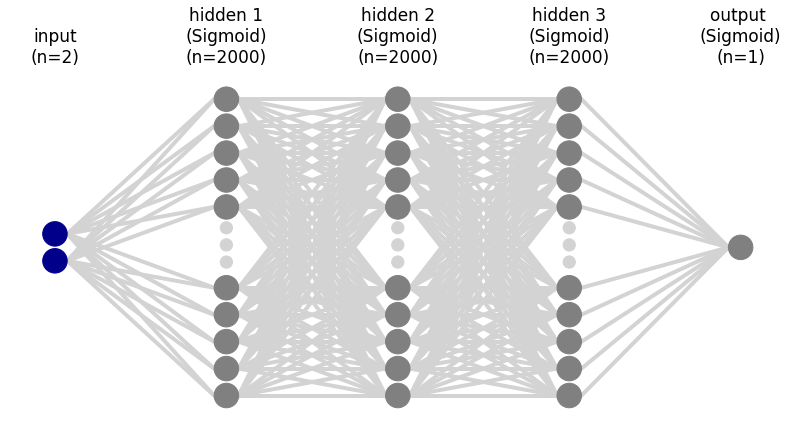

In [12]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

In [13]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [14]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [15]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [16]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [17]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              6000      
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2001      
Total params: 8,012,001
Trainable params: 8,012,001
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [18]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04027619  0.00556656 -0.01427691 ... -0.02504678 -0.01056639
   0.0320145 ]
 [-0.03984804 -0.04732465  0.02517711 ... -0.05462958  0.02752879
   0.05121659]]

 Biases for layer  1
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  2
[[ 0.03019984 -0.02509424  0.03596538 ...  0.03193791  0.02858563
  -0.02176725]
 [-0.0048652  -0.0093021  -0.03664855 ... -0.03543811  0.03227868
   0.03211344]
 [ 0.00300057  0.03435935  0.0360274  ... -0.03110942  0.02810709
  -0.00253981]
 ...
 [-0.00575778  0.00702398 -0.03209672 ... -0.02738092  0.03347227
   0.00419825]
 [ 0.00110932 -0.02100432 -0.03820309 ... -0.02372533 -0.01708016
  -0.00809786]
 [-0.02995123  0.03211863 -0.02091325 ... -0.03059827 -0.0194259
   0.02266547]]

 Biases for layer  2
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  3
[[ 0.03674223  0.01072497  0.00878111 ...  0.00173277  0.01814449
   0.02072984]
 [ 0.01286891 -0.03059675  0.0273809  ... -0.01630028 -0.01600991
  -0.0170859 ]
 [ 0.00238179  0.022213

## Save the weights generated by tf.keras and use them for our implementation as well

In [19]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 0.04027619, -0.03984804],
       [ 0.00556656, -0.04732465],
       [-0.01427691,  0.02517711],
       ...,
       [-0.02504678, -0.05462958],
       [-0.01056639,  0.02752879],
       [ 0.0320145 ,  0.05121659]], dtype=float32), array([[ 0.03019984, -0.0048652 ,  0.00300057, ..., -0.00575778,
         0.00110932, -0.02995123],
       [-0.02509424, -0.0093021 ,  0.03435935, ...,  0.00702398,
        -0.02100432,  0.03211863],
       [ 0.03596538, -0.03664855,  0.0360274 , ..., -0.03209672,
        -0.03820309, -0.02091325],
       ...,
       [ 0.03193791, -0.03543811, -0.03110942, ..., -0.02738092,
        -0.02372533, -0.03059827],
       [ 0.02858563,  0.03227868,  0.02810709, ...,  0.03347227,
        -0.01708016, -0.0194259 ],
       [-0.02176725,  0.03211344, -0.00253981, ...,  0.00419825,
        -0.00809786,  0.02266547]], dtype=float32), array([[ 0.03674223,  0.01286891,  0.00238179, ..., -0.00700544,
        -0.03286065,  0.02703295],
       [ 0.0

## Compile model

In [20]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [21]:
model.evaluate(inputs, outputs, batch_size=batchSize)

1/1 [==============================] - 0s 989us/step - loss: 0.2568 - mse: 0.2568


[0.2567862272262573, 0.2567862272262573]

## Does tf.model.evaluate change the weights and biases?

In [22]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04027619  0.00556656 -0.01427691 ... -0.02504678 -0.01056639
   0.0320145 ]
 [-0.03984804 -0.04732465  0.02517711 ... -0.05462958  0.02752879
   0.05121659]]

 Biases for layer  1
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  2
[[ 0.03019984 -0.02509424  0.03596538 ...  0.03193791  0.02858563
  -0.02176725]
 [-0.0048652  -0.0093021  -0.03664855 ... -0.03543811  0.03227868
   0.03211344]
 [ 0.00300057  0.03435935  0.0360274  ... -0.03110942  0.02810709
  -0.00253981]
 ...
 [-0.00575778  0.00702398 -0.03209672 ... -0.02738092  0.03347227
   0.00419825]
 [ 0.00110932 -0.02100432 -0.03820309 ... -0.02372533 -0.01708016
  -0.00809786]
 [-0.02995123  0.03211863 -0.02091325 ... -0.03059827 -0.0194259
   0.02266547]]

 Biases for layer  2
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  3
[[ 0.03674223  0.01072497  0.00878111 ...  0.00173277  0.01814449
   0.02072984]
 [ 0.01286891 -0.03059675  0.0273809  ... -0.01630028 -0.01600991
  -0.0170859 ]
 [ 0.00238179  0.022213

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=32 indicates that we are using all the training data(examples) in batches.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [23]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

1/1 [==============================] - 0s 1ms/step - loss: 0.2568 - mse: 0.2568


## Now the weights and biases must have been updated

In [24]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04027955  0.00556753 -0.01427054 ... -0.0250464  -0.01056414
   0.03201582]
 [-0.03984465 -0.04732367  0.02518347 ... -0.05462918  0.027531
   0.05121794]]

 Biases for layer  1
[6.7625897e-06 1.9821139e-06 1.2759869e-05 ... 7.8134974e-07 4.4432963e-06
 2.6482485e-06]

 Weights for layer  2
[[ 0.03018852 -0.02509252  0.03598116 ...  0.03194422  0.02860489
  -0.02177706]
 [-0.00487641 -0.00930041 -0.03663293 ... -0.03543187  0.03229774
   0.03210373]
 [ 0.00298921  0.03436106  0.03604322 ... -0.03110309  0.0281264
  -0.00254965]
 ...
 [-0.00576888  0.00702566 -0.03208125 ... -0.02737474  0.03349115
   0.00418863]
 [ 0.00109794 -0.0210026  -0.03818724 ... -0.02371899 -0.01706082
  -0.00810771]
 [-0.02996279  0.03212038 -0.02089714 ... -0.03059182 -0.01940624
   0.02265545]]

 Biases for layer  2
[-2.2648324e-05  3.4265963e-06  3.1562849e-05 ...  1.2625969e-05
  3.8511247e-05 -1.9625872e-05]

 Weights for layer  3
[[ 3.67073230e-02  1.08192535e-02  8.72795004e-

## Now let us do a forward feed again and calculate the loss/error

In [25]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

1/1 [==============================] - 0s 0s/step - loss: 0.5000 - mse: 0.5000
[0.4999889135360718, 0.4999889135360718]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs



In [26]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 2min 16s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [27]:
history.history

{'loss': [0.4999889135360718,
  0.4999889135360718,
  0.4999887943267822,
  0.4999887943267822,
  0.4999887943267822,
  0.4999886751174927,
  0.4999886751174927,
  0.4999886751174927,
  0.4999885559082031,
  0.4999885559082031,
  0.4999885559082031,
  0.4999884366989136,
  0.4999884366989136,
  0.4999884366989136,
  0.499988317489624,
  0.499988317489624,
  0.499988317489624,
  0.4999881982803345,
  0.4999881982803345,
  0.4999881982803345,
  0.4999880790710449,
  0.4999880790710449,
  0.4999880790710449,
  0.49998795986175537,
  0.49998795986175537,
  0.49998795986175537,
  0.4999878406524658,
  0.4999878406524658,
  0.49998778104782104,
  0.49998772144317627,
  0.49998772144317627,
  0.4999876022338867,
  0.4999876022338867,
  0.4999876022338867,
  0.49998748302459717,
  0.49998748302459717,
  0.4999873638153076,
  0.4999873638153076,
  0.4999873638153076,
  0.49998724460601807,
  0.49998724460601807,
  0.4999871253967285,
  0.4999871253967285,
  0.4999871253967285,
  0.4999870061874

## Now also let us have a look at the predictions for the sake of the tutorial

In [28]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[1.]
 [1.]
 [1.]
 [1.]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [29]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  4
Tensor("dense_2/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  4
Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32)


In [30]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  3
Tensor("dense_1/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  3
Tensor("dense_2/Identity:0", shape=(None, 2000), dtype=float32)

 Inputs for layer  4
Tensor("dense_2/Identity:0", shape=(None, 2000), dtype=float32)

 Outputs for layer  4
Tensor("dense_3/Identity:0", shape=(None, 1), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [31]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[0.5000033  0.49999964 0.5000044  ... 0.49999893 0.50000155 0.50000083]
 [0.49004427 0.48817056 0.50630057 ... 0.48634443 0.5068841  0.51280266]
 [0.51007265 0.5013911  0.4964375  ... 0.49373698 0.49736077 0.50800425]
 [0.50011367 0.48956132 0.5027339  ... 0.4800893  0.5042436  0.52079755]]

 Inputs for layer  2
[[0.5000033  0.49999964 0.5000044  ... 0.49999893 0.50000155 0.50000083]
 [0.49004427 0.48817056 0.50630057 ... 0.48634443 0.5068841  0.51280266]
 [0.51007265 0.5013911  0.4964375  ... 0.49373698 0.49736077 0.50800425]
 [0.50011367 0.48956132 0.5027339  ... 0.4800893  0.5042436  0.52079755]]

 Outputs for layer  2
[[0.45582056 0.36127365 0.3100369  ... 0.6269537  0.6033949  0.41613543]
 [0.45615518 0.35895818 0.30969572 ... 0.6284743  0.60328376 0.4167243 ]
 [0.45879793 0.36210975 0.31029353 ... 0.6293195  0.60590386 0.41905   ]
 [0.4591332  0.3597915  0.30995142 ... 0.63083637 0.6057929  0.41963

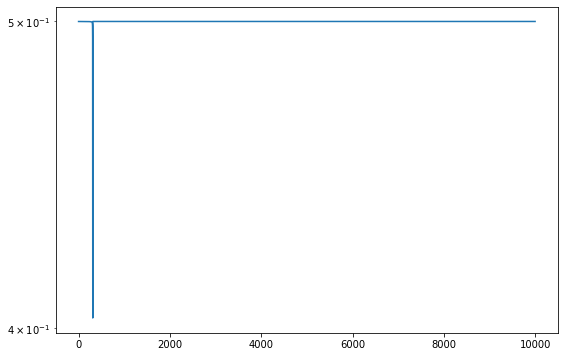

In [32]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [33]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## Backpropagation

In [34]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.20877738]
 [-0.29126984]
 [-0.29110923]
 [ 0.20884338]]
Gradient of Cost (error function) wrt weights:
 [array([[-6.7160981e-06, -6.7713172e-06],
       [-1.9493937e-06, -1.9685804e-06],
       [-1.2742665e-05, -1.2726250e-05],
       ...,
       [-7.6289439e-07, -7.9831716e-07],
       [-4.5078459e-06, -4.4236522e-06],
       [-2.6377788e-06, -2.7000710e-06]], dtype=float32), array([[ 2.26507400e-05,  2.24121595e-05,  2.27100572e-05, ...,
         2.21972368e-05,  2.27443470e-05,  2.31197191e-05],
       [-3.42741941e-06, -3.39126609e-06, -3.43558486e-06, ...,
        -3.35870482e-06, -3.44076398e-06, -3.49749234e-06],
       [-3.15673096e-05, -3.12345001e-05, -3.16483347e-05, ...,
        -3.09347161e-05, -3.16961414e-05, -3.22194428e-05],
       ...,
       [-1.26286341e-05, -1.24941944e-05, -1.26599225e-05, ...,
        -1.23731097e-05, -1.26792038e-05, -1.28903139e-05],
       [-3.85124258e-05, -3

## Gradient descent (update the weights and biases)

In [35]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.04027955, -0.03984465],
       [ 0.00556753, -0.04732367],
       [-0.01427054,  0.02518347],
       ...,
       [-0.0250464 , -0.05462918],
       [-0.01056414,  0.027531  ],
       [ 0.03201582,  0.05121794]], dtype=float32), array([[ 0.03018852, -0.00487641,  0.00298921, ..., -0.00576888,
         0.00109794, -0.02996279],
       [-0.02509252, -0.00930041,  0.03436106, ...,  0.00702566,
        -0.0210026 ,  0.03212038],
       [ 0.03598116, -0.03663293,  0.03604322, ..., -0.03208125,
        -0.03818724, -0.02089714],
       ...,
       [ 0.03194422, -0.03543187, -0.03110309, ..., -0.02737474,
        -0.02371899, -0.03059182],
       [ 0.02860489,  0.03229774,  0.0281264 , ...,  0.03349115,
        -0.01706082, -0.01940624],
       [-0.02177706,  0.03210373, -0.00254965, ...,  0.00418863,
        -0.00810771,  0.02265545]], dtype=float32), array([[ 3.67073230e-02,  1.28417108e-02,  2.35879538e-03, ...,
        -7.05265207e-03, -3.29059549e-02,  2.70009618

## Forward feed again and check the loss/error

In [36]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [37]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.25678626075387


KeyboardInterrupt: 

In [38]:
print(errorPlot)

NameError: name 'errorPlot' is not defined

In [ ]:
print(errorPlot)

#### Test the quality of the weights by running a forward feed again

In [ ]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [ ]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

In [ ]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [39]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.25678626075387
Wall time: 7min 23s


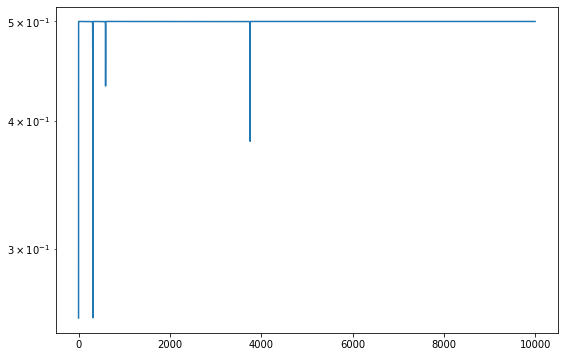

In [40]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [41]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.04027147, -0.03985269],
       [ 0.00555844, -0.04733221],
       [-0.01429532,  0.02515843],
       ...,
       [-0.02505527, -0.05463755],
       [-0.01057224,  0.02752261],
       [ 0.03201002,  0.05121219]], dtype=float32), array([[ 0.03021462, -0.00485136,  0.00301456, ..., -0.00574407,
         0.00112336, -0.02993618],
       [-0.02510577, -0.0093137 ,  0.03434794, ...,  0.00701243,
        -0.0210159 ,  0.03210701],
       [ 0.0359248 , -0.0366887 ,  0.03598671, ..., -0.0321365 ,
        -0.03824383, -0.02095385],
       ...,
       [ 0.03192949, -0.03544644, -0.03111747, ..., -0.0273888 ,
        -0.02373338, -0.03060642],
       [ 0.02849935,  0.03219308,  0.02802058, ...,  0.03338747,
        -0.0171668 , -0.01951395],
       [-0.02177479,  0.03210707, -0.00254781, ...,  0.00419047,
        -0.00810613,  0.02265773]], dtype=float32), array([[ 0.0367757 ,  0.01289531,  0.00240469, ..., -0.00695932,
        -0.03281718,  0.02706266],
       [ 0.

In [42]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
7.014349e-05
0.0001388407

Layer :  2
0.00023604184
0.00045925274

Layer :  3
0.000923926
0.00108581

Layer :  4
0.060571685
0.073504895


# PyTorch

In [43]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [44]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [45]:
Network = torch.nn.Sequential(*Layers)

In [46]:
print(Network)

Sequential(
  (0): Linear(in_features=2, out_features=2000, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2000, out_features=2000, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=2000, out_features=2000, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=2000, out_features=1, bias=True)
  (7): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [47]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [48]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=2000, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=2000, out_features=2000, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=2000, out_features=2000, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=2000, out_features=1, bias=True)
  (act3): Sigmoid()
)

## initial weights and biases generated by Pytorch

In [49]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.0211, -0.2553],
        [-0.4623, -0.0699],
        [ 0.2198,  0.2816],
        ...,
        [ 0.3705, -0.1089],
        [-0.4431,  0.5200],
        [ 0.5459, -0.5076]], requires_grad=True)
Parameter containing:
tensor([-0.6641, -0.3441, -0.4606,  ...,  0.1897, -0.1028, -0.3826],
       requires_grad=True)


## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [50]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [51]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 0.0403, -0.0398],
        [ 0.0056, -0.0473],
        [-0.0143,  0.0252],
        ...,
        [-0.0250, -0.0546],
        [-0.0106,  0.0275],
        [ 0.0320,  0.0512]])
Biases:

tensor([0., 0., 0.,  ..., 0., 0., 0.])
Weights:

tensor([[ 0.0302, -0.0049,  0.0030,  ..., -0.0058,  0.0011, -0.0300],
        [-0.0251, -0.0093,  0.0344,  ...,  0.0070, -0.0210,  0.0321],
        [ 0.0360, -0.0366,  0.0360,  ..., -0.0321, -0.0382, -0.0209],
        ...,
        [ 0.0319, -0.0354, -0.0311,  ..., -0.0274, -0.0237, -0.0306],
        [ 0.0286,  0.0323,  0.0281,  ...,  0.0335, -0.0171, -0.0194],
        [-0.0218,  0.0321, -0.0025,  ...,  0.0042, -0.0081,  0.0227]])
Biases:

tensor([0., 0., 0.,  ..., 0., 0., 0.])
Weights:

tensor([[ 0.0367,  0.0129,  0.0024,  ..., -0.0070, -0.0329,  0.0270],
        [ 0.0107, -0.0306,  0.0222,  ..., -0.0073, -0.0151,  0.0304],
        [ 0.0088,  0.0274,  0.0009,  ..., -0.0304,  0.0002,  0.0365],
        ...,
        [ 0.0017, -0.0163, -0.0283,

In [52]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=2, out_features=2000, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=2000, out_features=2000, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=2000, out_features=2000, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=2000, out_features=1, bias=True)
  (act3): Sigmoid()
)
8012001 trainable parameters


In [53]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [54]:
print(inputsTorch)
print(labels)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [60]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

  0%|          | 0/9999 [00:00<?, ?it/s]

Wall time: 3min 11s


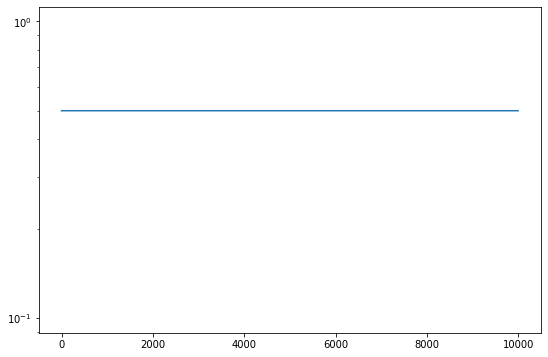

In [61]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [62]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(7.7805e-05)
tensor(0.0002)

Layer :  2
tensor(0.0003)
tensor(0.0005)

Layer :  3
tensor(0.0010)
tensor(0.0012)

Layer :  4
tensor(0.0676)
tensor(0.0821)


In [58]:
torch.get_num_threads()

8

In [60]:
# torch.set_num_threads(4)
torch.get_num_threads()

8

In [61]:
torch.get_num_threads()

8